In [1]:
import time

import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from matplotlib.colors import to_rgba
from torch import Tensor
from tqdm.notebook import tqdm  # Progress bar

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export

In [3]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
x

tensor([0., 1., 2.], requires_grad=True)

In [4]:
a = x+2
b = a**2
c = b+3
y = c.mean()
print("y", y)

y tensor(12.6667, grad_fn=<MeanBackward0>)


In [5]:
y.backward()

In [6]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


In [9]:
gpu_avail = torch.cuda.is_available()
gpu_avail

False

Contious XOR

In [10]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        pass

In [52]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [53]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)

print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [54]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


In [55]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continous_xor()
        
    def generate_continous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [56]:
dataset = XORDataset(size=200)
print("Size of dataset : ", len(dataset))
print("Data point 2 : ", dataset[2])

Size of dataset :  200
Data point 2 :  (tensor([0.0126, 0.0896]), tensor(0))


In [57]:
def visualize_samples(data, label):
    if isinstance(data, Tensor):
        data = data.cpu().numpy()
    if isinstance(label, Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

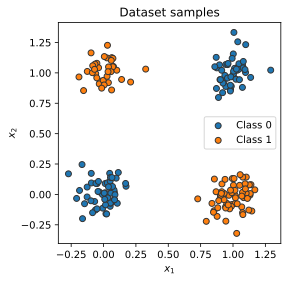

In [58]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [59]:
data_loader = data.DataLoader(dataset=dataset, batch_size=8, shuffle=True)

In [60]:
data_inputs, data_labels = next(iter(data_loader))

In [61]:
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[-0.0604,  0.9935],
        [ 0.0559, -0.0720],
        [ 1.0119,  1.0165],
        [ 0.0050,  0.9005],
        [-0.0661,  1.0717],
        [ 1.1362,  0.9624],
        [ 0.9794,  0.8984],
        [ 1.1686,  0.0379]])
Data labels torch.Size([8]) 
 tensor([1, 0, 0, 1, 1, 0, 0, 1])


In [62]:
loss_module = nn.BCEWithLogitsLoss()

In [63]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [64]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [65]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [66]:
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [67]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            
            loss = loss_module(preds, data_labels.float())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [68]:
train_model(model=model, optimizer=optimizer, data_loader=train_data_loader, loss_module=loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[ 2.5368, -2.1475],
        [-1.3434, -1.3278],
        [-0.0942, -0.4244],
        [-1.9207,  2.2933]])), ('linear1.bias', tensor([ 1.0349, -0.0484,  0.6295,  0.9328])), ('linear2.weight', tensor([[-2.9125, -1.9312,  0.8883, -2.7783]])), ('linear2.bias', tensor([0.8246]))])


In [71]:
torch.save(state_dict, "our_model.tar")

In [72]:
state_dict = torch.load("our_model.tar")

In [73]:
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

<All keys matched successfully>

In [74]:
test_dataset = XORDataset(size= 500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [75]:
def eval_model(model, data_loader):
    model.eval()
    true_preds, num_preds = 0.0, 0.0
    
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()
            
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]
            
    acc = true_preds/num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [76]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%
